In [1]:
import numpy as np
import pandas as pd
import math
import random
import bisect 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from ngboost import NGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.isotonic import IsotonicRegression

# Hide some warnings
pd.options.mode.chained_assignment = None 

In [2]:
# Load four sheets from excel file

denver = pd.read_excel('Datas.xls', sheet_name='DEN')
newyork = pd.read_excel('Datas.xls', sheet_name='NYC')
sanfrancisco = pd.read_excel('Datas.xls', sheet_name='SFC')
texas = pd.read_excel('Datas.xls', sheet_name='TXS')

# Set random seed
random.seed(48)

In [3]:
# Cleen data to make it easier to handle

denver['station'] = denver['station'].replace(np.nan,'DENVER INTL AP')
denver['station'] = denver['station'].replace('DENVER INTL AP', 'DEN')
newyork['station'] = newyork['station'].replace(np.nan, 'JFK')
sfc = sanfrancisco.drop(columns = 'valid', axis=1)

In [4]:
#Function to rename columns 

def rename_columns(df, col_names):
    cols = df.columns
    for col, new_col in zip(cols, col_names):
        df.rename(columns={col:new_col}, inplace=True)

In [5]:
# Rename columns in all datasets to same column names

col_names = ['station', 'skycloud', 'day', 'tmpf', 'feel', 
             'zenith', 'azimuth', 'glob', 'direct', 
             'diffused', 'albedo', 'time', 'power']

rename_columns(denver, col_names)
rename_columns(newyork, col_names)
rename_columns(sfc, col_names)
rename_columns(texas, col_names)

In [6]:
# Join all 4 datasets into a single dataframe

frames = [denver, newyork, sfc, texas]
data = pd.concat(frames)


# Create dataset for denver station
den = data.loc[data['station'] == 'DEN']

In [7]:
# Drop columns with low correlation

den = den.drop(columns = ['skycloud', 'feel', 'albedo'], axis=1)

In [8]:
# Drop rows with azimuth = -99 values

den.drop(den.index[den['azimuth'] == -99], inplace = True)

In [9]:
# Create X and y values

X_val = den.drop(columns = ['station', 'power','day'], axis=1) 
X = X_val.values
y = den.power.values

In [10]:
# Train test split and scale data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=300, random_state=48, shuffle=True)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

scaler = MinMaxScaler()
X_tr_sc = scaler.fit_transform(X_train)
X_te_sc = scaler.transform(X_test)
y_tr_sc = scaler.fit_transform(y_train)
y_te_sc = scaler.transform(y_test)

In [11]:
X_calib, X_true_test, y_calib, y_true_test = train_test_split(X_te_sc, y_te_sc, test_size=0.5, random_state=48, shuffle=True)

In [12]:
# Create length scale and length scale bounds

feature_len = len(X_tr_sc[0])
len_scale = np.ones(feature_len)

hp_low = 1e-10
hp_high = 100000

hp_bounds = np.zeros(shape = (feature_len,2))
hp_bounds[:,0] = hp_low
hp_bounds[:,1] = hp_high

In [13]:
# sklearn gpr model matern 52 kernel + white kernel
def gpr_model(len_sc, hp_b, X_tr, y_tr, X_cal, X_test):
    kernel = Matern(length_scale=len_sc, length_scale_bounds=hp_b, nu=2.5) + WhiteKernel(noise_level=0.1)
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(X_tr, y_tr)
    mean_calib, std_calib = model.predict(X_cal, return_std=True)
    mean_true_test, std_true_test = model.predict(X_test, return_std=True)
    
    return mean_calib, std_calib, mean_true_test, std_true_test

TypeError: float() argument must be a string or a number, not 'Matern'

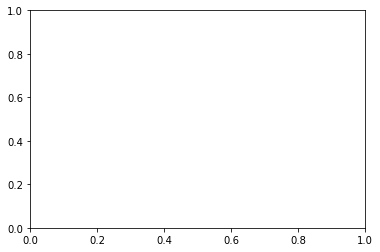

In [130]:
plt.plot(Matern(length_scale=len_scale, length_scale_bounds=hp_bounds, nu=2.5))

In [14]:
gpr_mean_calib, gpr_std_calib, gpr_mean_true_test, gpr_std_true_test = gpr_model(len_scale, hp_bounds, X_tr_sc, y_tr_sc, X_calib, X_true_test)

In [15]:
def ngb_model(X_tr, y_tr, X_cal, X_test):
    ngb = NGBRegressor()
    ngb.fit(X_tr, y_tr)
    ngb_preds_calib = ngb.pred_dist(X_cal)
    ngb_preds_test = ngb.pred_dist(X_test)
    
    mean_calib = ngb_preds_calib.params['loc']
    std_calib = ngb_preds_calib.params['scale']
    mean_test = ngb_preds_test.params['loc']
    std_test = ngb_preds_test.params['scale']
    
    return mean_calib, std_calib, mean_test, std_test

In [16]:
ngb_mean_calib, ngb_std_calib, ngb_mean_true_test, ngb_std_true_test = ngb_model(X_tr_sc, y_tr_sc, X_calib, X_true_test)

C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[iter 0] loss=0.2639 val_loss=0.0000 scale=1.0000 norm=0.4704
[iter 100] loss=-0.4870 val_loss=0.0000 scale=2.0000 norm=0.8366
[iter 200] loss=-1.0777 val_loss=0.0000 scale=2.0000 norm=0.8157
[iter 300] loss=-1.4716 val_loss=0.0000 scale=2.0000 norm=0.7935
[iter 400] loss=-1.7144 val_loss=0.0000 scale=2.0000 norm=0.7963


### CRUDE Calibration

In [17]:
def find_z_scores(y_calib, mean_calib, std_calib):
    z_calib = []

    for i in range(len(mean_calib)):
        dif = y_calib[i] - mean_calib[i] 
        z_st = dif/std_calib[i]
        bisect.insort(z_calib, z_st) #sorted list of z_star values

    # This is noted as Zc in the article
    z_c = np.concatenate(z_calib, axis=0 )  
    
    return z_c

In [18]:
# function to find quantiles, p is the target quantile level

def CRUDE(z_c, mean_calib):
    p_values = np.arange(0.05,1,0.05)
    
    # empty 2d array for z_p scores for all p values
    z_p = np.zeros((len(p_values), 2))
    
    for p in range(len(p_values)):
        
        #define higher and lower boundries
        p_up = round(p_values[p]+(1-p_values[p])/2, 3)
        p_low = round(1-p_up, 3)

        #determine which Zc values to include in both boundries
        z_p_up = z_c[int(p_up * len(mean_calib))]
        z_p_low = z_c[int(p_low * len(mean_calib))]
        
        z_p[p,0] = z_p_low
        z_p[p,1] = z_p_up
        
    return z_p

In [19]:
def find_quantiles(z_p, mean_true_test, std_true_test):
 
    # empty 2*z_p array for lower and higher boundry values
    q = np.zeros((len(mean_true_test), 2*len(z_p)))
    index = 0
    
    for j in range(len(z_p)):  
        for i in range(len(mean_true_test)):
            #Define the lower and higher boundry for each data point
            q_low = mean_true_test[i] + std_true_test[i] * z_p[j,0]
            q_up = mean_true_test[i] + std_true_test[i] * z_p[j,1]
            
            q[i,index] = q_low
            q[i,index + 1] = q_up
        
        index = index + 2       
    return q

In [20]:
def crude_coverage(q, y_true_test):

    p_values = np.arange(0.05,1,0.05)
    cov = []
    index = 0

    for p in p_values:
        count = 0
        for i in range(len(q)):
            if (y_true_test[i] > q[i,index]) and (y_true_test[i] < q[i,index+1]):
                count = count + 1 
        index = index + 2
        cov.append(count/len(q))
        
    return cov

In [21]:
z_c_gpr = find_z_scores(y_calib, gpr_mean_calib, gpr_std_calib)
z_p_gpr = CRUDE(z_c_gpr, gpr_mean_calib)
q_gpr = find_quantiles(z_p_gpr, gpr_mean_true_test, gpr_std_true_test)
cov_crude_gpr = crude_coverage(q_gpr, y_true_test)

In [22]:
z_c_ngb = find_z_scores(y_calib, ngb_mean_calib, ngb_std_calib)
z_p_ngb = CRUDE(z_c_ngb, ngb_mean_calib)
q_ngb = find_quantiles(z_p_ngb, ngb_mean_true_test, ngb_std_true_test)
cov_crude_ngb = crude_coverage(q_ngb, y_true_test)

### Kuleshov calibration

In [23]:
def find_conf_interval(mean_calib, y_calib, std_calib):

    cdfs = []

    for i in range(len(mean_calib)):
        dif = y_calib[i] - mean_calib[i] 
        z_st = dif/std_calib[i]
        cdf = stats.norm.cdf(z_st)
        cdfs.append(cdf)

#         if cdf < 0.5:
#             centered.append(1 - 2*cdf)
#         else:
#             centered.append(cdf - (1-cdf))

    # This is the Ft from the article
    CI_cent = np.concatenate(cdfs, axis=0 )   
    
    return CI_cent

In [24]:
def find_coverage(CI_cent):
    
    cover_cent = []

    for i in range(len(CI_cent)):
        count = 0
        for j in range(len(CI_cent)):
            if CI_cent[j] < CI_cent[i]:
                count = count +1
        cov_cent = count/len(CI_cent)
        cover_cent.append(cov_cent)
    
    return cover_cent

In [25]:
p_values = np.arange(0.05,1,0.05)

for p in range(len(p_values)):

    #define higher and lower boundries
    p_up = round(p_values[p]+(1-p_values[p])/2, 3)
    p_low = round(1-p_up, 3)
    
    print(p_up, p_low)

0.525 0.475
0.55 0.45
0.575 0.425
0.6 0.4
0.625 0.375
0.65 0.35
0.675 0.325
0.7 0.3
0.725 0.275
0.75 0.25
0.775 0.225
0.8 0.2
0.825 0.175
0.85 0.15
0.875 0.125
0.9 0.1
0.925 0.075
0.95 0.05
0.975 0.025


In [26]:
q_dist = np.random.rand()
print(q_dist)

0.5023953356707617


In [38]:
tol = 0.001
delta_mid = 2*tol
q_lower = -10
q_upper = 10 * max(ngb_mean_true_test)
q_mid = 0.5 * (q_lower + q_upper)

print(delta_mid, q_lower, q_upper, q_mid)

e_low = stats.norm.cdf(ngb_mean_true_test[0]-q_mid)
e_upp = stats.norm.cdf(ngb_mean_true_test[0]+q_mid)

e_low1 = stats.norm.cdf(ngb_mean_true_test[1]-q_mid)
e_upp1 = stats.norm.cdf(ngb_mean_true_test[1]+q_mid)

print(e_low, e_upp)
print(e_low1, e_upp1)

0.002 -10 9.323942102590161 -0.3380289487049195
0.6322629868775436 0.3676043633958948
0.632733759620484 0.3680752789951832


In [118]:
def train_ir_calc_coverage(CI_cent, cover_cent, mean_true_test, y_true_test, std_true_test):

    ir = IsotonicRegression()
    # empirical (H) first and predicted (P) next
    h = ir.fit_transform(CI_cent, cover_cent)

    coverage_cal_cent = []
    coverage_uncal_cent = []

    p_values = np.arange(0.05,1,0.05)
    cdf_cals = np.zeros((len(mean_true_test), 1))
    cdf_uncals = np.zeros((len(mean_true_test), 1))
    limits = np.zeros((len(mean_true_test), len(p_values)))
    
    for p in range(len(p_values)):
        count_cal = 0
        count_uncal = 0
        
        #get upper and lower p values
        p_up = round(p_values[p]+(1-p_values[p])/2, 3)
        p_low = round(1-p_up, 3)
        
#         tol = 0.001
#         delta_mid = 2*tol
#         q_lower = -10
#         q_upper = 10 * max(mean_true_test)
#         q_mid = 0.5 * (q_lower + q_upper)

        for j in range(len(mean_true_test)):
            dif = y_true_test[j] - mean_true_test[j]
            z_st = dif/std_true_test[j]   
            cdf_uncal = stats.norm.cdf(z_st)
            
            tol = 0.001
            delta_mid = 2*tol
            q_lower = 0
            q_upper = 10 * max(mean_true_test)
            q_mid = 0.5 * (q_lower + q_upper)
            
            #recalibrate the cdfs using the trained isotonic regression model
            cdf_cal = ir.predict(cdf_uncal)
            
            while abs(delta_mid) > tol:
                q_mid = 0.5*(q_upper + q_lower)
                
                e_low = stats.norm.cdf(mean_true_test[j]-q_mid)
                e_upp = stats.norm.cdf(mean_true_test[j]+q_mid)

                e_low = e_low.reshape((1, 1))
                e_upp = e_upp.reshape((1, 1))

                s_low = ir.predict(e_low)
                s_upp = ir.predict(e_upp)
                
                true_ci = s_upp - s_low
                delta_mid = true_ci - p_values[p]

                if delta_mid > 0:
                    q_upper = q_mid
                else:
                    q_lower = q_mid
                    
            limits[j, p] = q_mid
                    
            
#             if j <20:
#                 print(q_mid)
#             limits[j, index] = q_mid
            
            #Get cdfs, both calculated and uncalculated
            cdf_cals[j,0] = cdf_cal
            cdf_uncals[j,0] = cdf_uncal

            #calculate coverage
            if cdf_cal <= p_values[p]:
                count_cal = count_cal+1

            if cdf_uncal <= p_values[p]:
                count_uncal = count_uncal+1

        print('Computed p limit')
        coverage_cal_cent.append(count_cal/len(mean_true_test))
        coverage_uncal_cent.append(count_uncal/len(mean_true_test))
        
    return coverage_cal_cent, coverage_uncal_cent, cdf_cals, cdf_uncals, limits

In [28]:
conf_int_ngb = find_conf_interval(ngb_mean_calib, y_calib, ngb_std_calib)
coverage_ngb = find_coverage(conf_int_ngb)

In [120]:
cov_kuleshov_calc_ngb, cov_uncal_ngb, cdf_cals_ngb, cdf_uncals_ngb, limits_ngb = train_ir_calc_coverage(conf_int_ngb, coverage_ngb, 
                                                                            ngb_mean_true_test, y_true_test, ngb_std_true_test)

Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit


In [121]:
print(limits_ngb)

[[0.09788318 0.15479201 0.26860966 ... 3.18689427 4.00638137 5.49966897]
 [0.09902136 0.15251565 0.26747148 ... 3.18689427 4.00638137 5.49966897]
 [0.09560683 0.15479201 0.27088601 ... 3.18689427 4.00638137 5.49966897]
 ...
 [0.14113389 0.3004786  0.40163404 ... 3.29615922 4.15206797 5.82746381]
 [0.09560683 0.15479201 0.27088601 ... 3.18689427 4.00638137 5.49966897]
 [0.04780341 0.16389742 0.3004786  ... 3.16868345 4.00638137 5.68177722]]


In [122]:
conf_int_gpr = find_conf_interval(gpr_mean_calib, y_calib, gpr_std_calib)
coverage_gpr = find_coverage(conf_int_gpr)
cov_kuleshov_calc_gpr, cov_uncal_gpr, cdf_cals_gpr, cdf_uncals_gpr, limits_gpr = train_ir_calc_coverage(conf_int_gpr, coverage_gpr, 
                                                                            gpr_mean_true_test, y_true_test, gpr_std_true_test)

Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit
Computed p limit


In [127]:
ans = np.zeros((len(p_values), 1))

for p in range(len(p_values)):
    count = 0
    for i in range(len(limits_ngb)):
        if y_true_test[i] < ngb_mean_true_test[i] + limits_ngb[i,p] and y_true_test[i] > ngb_mean_true_test[i] - limits_ngb[i,p]:
            count = count+1

    ans[p,0] = count/len(limits_ngb)

In [128]:
print(ans)

[[0.72387728]
 [0.85682526]
 [0.92752334]
 [0.957759  ]
 [0.98799466]
 [0.99688751]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]]


In [ ]:
X_len = 20
x = np.arange(X_len) 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17,5))

ax1.plot(x[:X_len], ngb_mean_true_test[0:X_len], label='predicted')
#ax1.plot(x[:X_len])
ax1.fill_between(x[:X_len], ppf_ngb[0:X_len,0], ppf_ngb[0:X_len,37],
                 color='gray', alpha=0.2)
ax1.fill_between(x[:X_len], ppf_ngb[0:X_len,10], ppf_ngb[0:X_len,26],
                 color='salmon', alpha=0.2)

ax2.plot(x[:X_len], ngb_mean_true_test[0:X_len], label='predicted')
ax2.fill_between(x[:X_len], ppf_ngb[0:X_len,17], ppf_ngb[0:X_len,19],
                 color='gray', alpha=0.2)

ax3.plot(x[:X_len], ngb_mean_true_test[0:20], label='predicted')
ax3.fill_between(x[:X_len], ngb_mean_true_test[0:20] - cdf_cals_ngb[0:20,0]/2, ngb_mean_true_test[0:20] + cdf_cals_ngb[0:20,0]/2,
                 color='gray', label='kuleshov calibrated intervals', alpha=0.2)
plt.show()

In [ ]:

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

# ax1.plot(x[:X_len], gpr_mean_true_test[0:X_len], label='predicted')
# ax1.fill_between(x[:X_len], ppf_gpr[0:X_len,20], ppf_gpr[0:X_len,21],
#                  color='gray', alpha=0.2)
# ax1.fill_between(x[:X_len], ppf_gpr[0:X_len,10], ppf_gpr[0:X_len,11],
#                  color='salmon', alpha=0.2)

# ax2.plot(x[:X_len], gpr_mean_true_test[0:X_len], label='predicted')
# ax2.fill_between(x[:X_len], ppf_gpr[0:X_len,2], ppf_gpr[0:X_len,3],
#                  color='gray', alpha=0.2)

# ax3.plot(x[:X_len], gpr_mean_true_test[0:20], label='predicted')
# ax3.fill_between(x[:X_len], gpr_mean_true_test[0:20] - cdf_cals_gpr[0:20,0]/2, gpr_mean_true_test[0:20] + cdf_cals_gpr[0:20,0]/2,
#                  color='gray', label='kuleshov calibrated intervals', alpha=0.2)
# plt.show()


### Testing some combination

In [87]:
def ranges(q, mean_true_test, ppf):
    crude_range = np.zeros((len(q), 2))
    kuleshov_range = np.zeros((len(q), 2))

    for i in range(len(q)):
        crude_range[i,0] = q[i,34]
        kuleshov_range[i,0] = mean_true_test[i] - ppf[i,18]

        crude_range[i,1] = q[i,35]
        kuleshov_range[i,1] = mean_true_test[i] + ppf[i,18]
    
    return crude_range, kuleshov_range

In [88]:
ngb_crude_range, ngb_kuleshov_range = ranges(q_ngb, ngb_mean_true_test, limits_ngb)
gpr_crude_range, gpr_kuleshov_range = ranges(q_gpr, gpr_mean_true_test, ppf_gpr)

In [89]:
def comb_intervals1(crude_range, kuleshov_range):
    comb_intervals = np.zeros((len(crude_range), 2))

    for i in range(len(crude_range)):
        crude_dif = (crude_range[i,1] - crude_range[i,0])
        kuleshov_dif = (kuleshov_range[i,1]- kuleshov_range[i,0])
        
        if crude_dif < kuleshov_dif or np.isnan(kuleshov_dif):
            comb_intervals[i,0] = crude_range[i,0]
            comb_intervals[i,1] = crude_range[i,1]
        else:
            comb_intervals[i,0] = kuleshov_range[i,0]
            comb_intervals[i,1] = kuleshov_range[i,1]
        
    return comb_intervals

In [90]:
def comb_intervals2(crude_range, kuleshov_range):
    comb_intervals = np.zeros((len(crude_range), 2))

    for i in range(len(crude_range)):
        comb_intervals[i,1] = min(crude_range[i,1], kuleshov_range[i,1])
        comb_intervals[i,0] = max(crude_range[i,0], kuleshov_range[i,0])
        
    return comb_intervals

In [91]:
ngb_comb_intervals = comb_intervals1(ngb_crude_range, ngb_kuleshov_range)
gpr_comb_intervals = comb_intervals1(gpr_crude_range, gpr_kuleshov_range)

ngb_comb_intervals2 = comb_intervals2(ngb_crude_range, ngb_kuleshov_range)
gpr_comb_intervals2 = comb_intervals2(gpr_crude_range, gpr_kuleshov_range)

In [ ]:
X_len = 50
x = np.arange(X_len)  

fig, ax = plt.subplots(1,1, figsize=(15, 6))
plt.plot(x[:X_len], y_true_test[0:50], label='real')
plt.plot(x[:X_len], ngb_mean_true_test[0:50], '--', label='predicted')
plt.fill_between(x[:X_len], ngb_mean_true_test[0:50] - cdf_uncals_ngb[0:50,0]/2, ngb_mean_true_test[0:50] + cdf_uncals_ngb[0:50,0]/2,
                 color='gray', label='uncalibrated intervals', alpha=0.2)
plt.ylim(-0.55, 1.5)

plt.legend()
plt.show()

fig, ax = plt.subplots(1,1, figsize=(15, 6))
plt.plot(x[:X_len], y_true_test[0:50], label='real')
plt.plot(x[:X_len], ngb_mean_true_test[0:50], '--', label='predicted')
plt.fill_between(x[:X_len], ngb_mean_true_test[0:50] - cdf_cals_ngb[0:50,0]/2, ngb_mean_true_test[0:50] + cdf_cals_ngb[0:50,0]/2,
                 color='gray', label='kuleshov calibrated intervals', alpha=0.2)
plt.ylim(-0.55, 1.5)

plt.legend()
plt.show()

fig, ax = plt.subplots(1,1, figsize=(15, 6))
plt.plot(x[:X_len], y_true_test[0:50], label='real')
plt.plot(x[:X_len], ngb_mean_true_test[0:X_len], '--', label='predicted')
plt.fill_between(x[:X_len], ppf_ngb[0:X_len,0], ppf_ngb[0:X_len,37],
                 color='gray', alpha=0.2, label='kuleshov ppf 0.95')
plt.fill_between(x[:X_len], ppf_ngb[0:X_len,10], ppf_ngb[0:X_len,27],
                 color='salmon', alpha=0.2)
plt.ylim(-0.55, 1.5)

plt.legend()
plt.show()

fig, ax = plt.subplots(1,1, figsize=(15, 6))
plt.plot(x[:X_len], y_true_test[0:50], label='real')
plt.plot(x[:X_len], gpr_mean_true_test[0:50], '--', label='predicted')
plt.fill_between(x[:X_len], q_gpr[0:50,36], q_gpr[0:50,37],
                 color='gray', label='CRUDE calibrated intervals', alpha=0.2)
plt.ylim(-0.55, 1.5)

plt.legend()
plt.show()

fig, ax = plt.subplots(1,1, figsize=(15, 6))
plt.plot(x[:X_len], y_true_test[0:50], label='real')
plt.plot(x[:X_len], ngb_mean_true_test[0:50], '--', label='predicted')
plt.fill_between(x[:X_len], ngb_comb_intervals[0:50,0], ngb_comb_intervals[0:50,1],
                 color='gray', label='combined calibrated intervals', alpha=0.2)
plt.ylim(-0.55, 1.5)

plt.legend()
plt.show()

fig, ax = plt.subplots(1,1, figsize=(15, 6))
plt.plot(x[:X_len], y_true_test[0:50], label='real')
plt.plot(x[:X_len], ngb_mean_true_test[0:50], '--', label='predicted')
plt.fill_between(x[:X_len], ngb_comb_intervals2[0:50,0], ngb_comb_intervals2[0:50,1],
                 color='gray', label='combined calibrated intervals', alpha=0.2)
plt.ylim(-0.55, 1.5)

plt.legend()
plt.show()

### Calculating sharpness

In [ ]:
def get_st_dev(interval):
    std_dev = np.zeros((len(interval), 1))
    for i in range(len(interval)):
        std_dev[i] = interval[i,1] - interval[i,0]
    return std_dev

In [ ]:
ngb_std_crude = get_st_dev(ngb_crude_range)
gpr_std_crude = get_st_dev(gpr_crude_range)

ngb_std_comb = get_st_dev(ngb_comb_intervals)
gpr_std_comb = get_st_dev(gpr_comb_intervals)

ngb_std_comb2 = get_st_dev(ngb_comb_intervals2)
gpr_std_comb2 = get_st_dev(gpr_comb_intervals2)

In [ ]:
def calc_sharpness(cdf_cals):

    var_ngb = 0
    count_nan = 0
    for i in range(len(cdf_cals)):
        if math.isnan(cdf_cals[i]):
            count_nan = count_nan + 1
        else:
            var_ngb = var_ngb + pow(cdf_cals[i], 2)


    sharpness = var_ngb/(len(cdf_cals-count_nan))
    return sharpness

In [ ]:
st_dev = [cdf_cals_ngb, cdf_cals_gpr, ngb_std_crude, gpr_std_crude, 
          ngb_std_comb, gpr_std_comb, ngb_std_comb2, gpr_std_comb2]
names = ['Kuleshov NgBoost', 'Kuleshov GPR', 'CRUDE NgBoost', 'CRUDE GPR',
        'Comb 1 NgBoost', 'Comb 1 GPR', 'Comb 2 NgBoost', 'Comb 2 GPR']

sharp_ngb = np.zeros((int(len(names)/2), 1))
sharp_gpr = np.zeros((int(len(names)/2), 1))
for dev, i in zip(st_dev, range(len(names))):
    if i%2 < 1:
        sharpness = calc_sharpness(dev)
        sharp_ngb[int(i/2)] = sharpness
    else:
        sharpness = calc_sharpness(dev)
        sharp_gpr[int(i/2)] = sharpness
        
    print(names[i], sharpness)


In [ ]:
sharp_ngb = np.concatenate(sharp_ngb, axis=0 )
sharp_gpr = np.concatenate(sharp_gpr, axis=0 )

In [ ]:
index = np.arange(4)
bar_width = 0.35

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.bar(index, sharp_gpr, bar_width, label='Gaussian process regression')
plt.bar(index + bar_width, sharp_ngb, bar_width, label='NgBoost')
plt.xticks(index + bar_width/2, ('Kuleshov', 'CRUDE', 'Combination 1', 'Combination 2'))
plt.ylabel('Sharpness')

plt.legend()
plt.show()

### When not to trust your model

In [ ]:
# st_dev = [cdf_cals_ngb, cdf_cals_gpr, ngb_std_crude, gpr_std_crude, 
#           ngb_std_comb, gpr_std_comb, ngb_std_comb2, gpr_std_comb2]

flagged = np.zeros((len(cdf_cals_ngb), len(st_dev)))
index = 0

for dev in st_dev:
    for i in range(len(dev)):
        if dev[i] > 0.8:
            flagged[i, index] = 1
    index = index + 1
            

In [ ]:
num_ones = sum(cell for row in flagged for cell in row)
print(num_ones)

In [ ]:
print(flagged.size)
print(num_ones/flagged.size)

### Combination coverage

In [92]:
def comb_coverage(comb, y_true_test):
   
    cov = []
    p_values = np.arange(0.05,1,0.05)
    
    for p in p_values:
        count = 0
        for i in range(len(comb)):
            comb_range = comb[i,1] - comb[i,0] 
            if comb_range < p:
                count = count + 1
        cov.append(count/len(comb))
        
    return cov

In [93]:
comb_cov_ngb = comb_coverage(ngb_comb_intervals, y_true_test)
comb_cov_gpr = comb_coverage(gpr_comb_intervals, y_true_test)

comb_cov_ngb2 = comb_coverage(ngb_comb_intervals2, y_true_test)
comb_cov_gpr2 = comb_coverage(gpr_comb_intervals2, y_true_test)

In [ ]:
len(comb_cov_ngb)

In [70]:
cov_kuleshov_gpr = np.zeros((len(cov_crude_gpr),1))
cov_kuleshov_ngb = np.zeros((len(cov_crude_gpr),1))
cov_unc_gpr = np.zeros((len(cov_crude_gpr),1))
cov_unc_ngb = np.zeros((len(cov_crude_gpr),1))

index = 0

for i in range(len(cov_kuleshov_calc_gpr)):
    if i%2==0:
        cov_kuleshov_gpr[index] = cov_kuleshov_calc_gpr[i]
        cov_kuleshov_ngb[index] = cov_kuleshov_calc_ngb[i]
        cov_unc_gpr[index] = cov_uncal_gpr[i]
        cov_unc_ngb[index] = cov_uncal_ngb[i]
        index = index + 1


### Comparison of coverage/recalibration

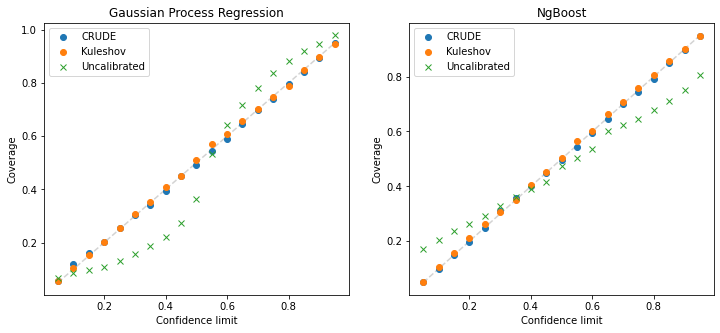

In [97]:
x = np.linspace(0.05, 0.95, 19)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(x, x + 0, linestyle="dashed", color='lightgray')
ax1.plot(x, cov_crude_gpr, 'o', label='CRUDE')
ax1.plot(x, cov_kuleshov_calc_gpr, 'o', label='Kuleshov')
ax1.plot(x, cov_uncal_gpr, 'x', label='Uncalibrated')
# ax1.plot(x, comb_cov_gpr, '+', label='Combination 1')
# ax1.plot(x, comb_cov_gpr2, 'x', label='Combination 2')
ax1.set_xlabel('Confidence limit')
ax1.set_ylabel('Coverage')
ax1.set_title('Gaussian Process Regression')
ax1.legend()

ax2.plot(x, x + 0, linestyle="dashed", color='lightgray')
ax2.plot(x, cov_crude_ngb, 'o', label='CRUDE')
ax2.plot(x, cov_kuleshov_calc_ngb, 'o', label='Kuleshov')
ax2.plot(x, cov_uncal_ngb, 'x', label='Uncalibrated')
# ax2.plot(x, comb_cov_ngb, '+', label='Combination 1')
# ax2.plot(x, comb_cov_gpr2, 'x', label='Combination 2')
ax2.set_xlabel('Confidence limit')
ax2.set_ylabel('Coverage')
ax2.set_title('NgBoost')
ax2.legend()

plt.show()

In [178]:
# from scipy.stats import norm

# data_2 = np.arange(-4,4,0.01)
# pdf = norm.pdf(data_2 , loc = 0 , scale = 1 )
 
# #Visualizing the distribution
 
# # sns.set_style('whitegrid')
# # sns.lineplot(data_2, pdf , color = 'black')

# plt.plot(data_2, pdf)
# y2 = plt.axvline(x=-1, ls='--', color='orange')
# plt.fill_between(data_2, pdf, y_vals, color='#539ecd')
# # plt.xlabel('Heights')
# # plt.ylabel('Probability Density')
# plt.show()

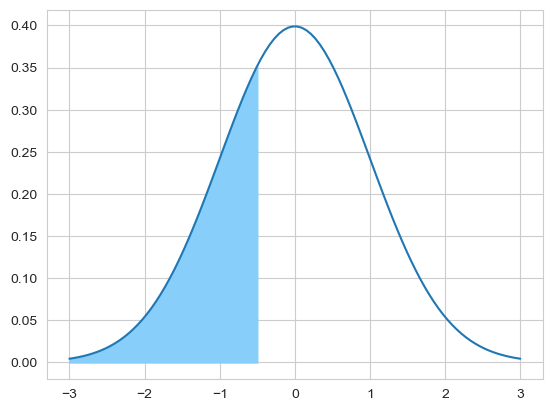

In [192]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as stats
plt.style.use('default')
sns.set_style('whitegrid')

mean=0
std=1

x=np.linspace(mean-3*std, mean+3*std,100)
iq=stats.norm(mean,std)
plt.plot(x,iq.pdf(x))
px=np.arange(-3,-0.4,0.1)
plt.fill_between(px,iq.pdf(px), color='lightskyblue')

plt.show()

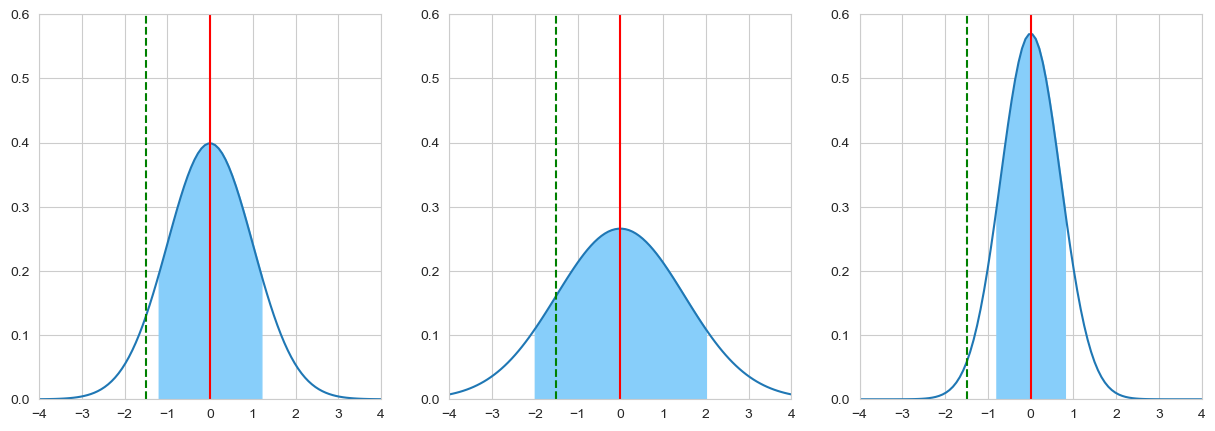

In [220]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as stats
plt.style.use('default')
sns.set_style('whitegrid')

x=np.linspace(mean-4*std, mean+4*std,100)

mean=0
std=1
iq=stats.norm(mean,std)
px=np.arange(-1.2,1.3,0.1)

std2=1.5
iq2=stats.norm(mean,std2)
px2=np.arange(-2.0,2.1,0.1)

std3=0.7
iq3=stats.norm(mean,std3)
px3=np.arange(-0.8,0.9,0.1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(x,iq.pdf(x))
ax1.axvline(x=-1.5, ls='--', color='green')
ax1.axvline(x=0, ls='-', color='red')
ax1.fill_between(px,iq.pdf(px), color='lightskyblue')
ax1.set_ylim(0,0.6)
ax1.set_xlim(-4,4)
#ax1.set_title('Mean = 0, standard deviation = 1')

ax2.plot(x,iq2.pdf(x))
ax2.axvline(x=-1.5, ls='--', color='green')
ax2.axvline(x=0, ls='-', color='red')
ax2.fill_between(px2,iq2.pdf(px2), color='lightskyblue')
ax2.set_ylim(0,0.6)
ax2.set_xlim(-4,4)
#ax2.set_title('Mean = 0, standard deviation = 1.5')

ax3.plot(x,iq3.pdf(x))
ax3.axvline(x=-1.5, ls='--', color='green')
ax3.axvline(x=0, ls='-', color='red')
ax3.fill_between(px3,iq3.pdf(px3), color='lightskyblue')
ax3.set_ylim(0,0.6)
ax3.set_xlim(-4,4)
#ax3.set_title('Mean = 0, standard deviation = 0.7')

plt.show()

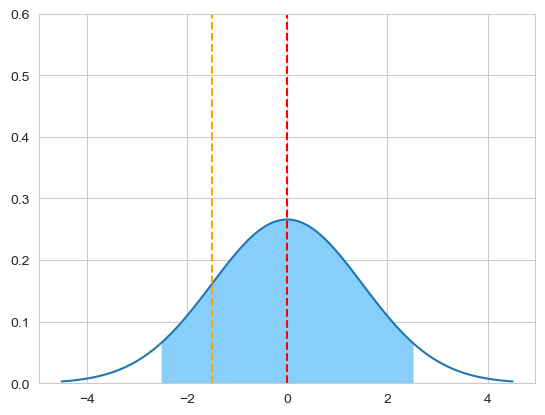

In [206]:
mean=0
std=1.5

x=np.linspace(mean-3*std, mean+3*std,100)
iq=stats.norm(mean,std)
plt.plot(x,iq.pdf(x))
px=np.arange(-2.5,2.6,0.1)
plt.axvline(x=-1.5, ls='--', color='orange')
plt.axvline(x=0, ls='--', color='red')
plt.fill_between(px,iq.pdf(px), color='lightskyblue')
plt.ylim(0,0.6)

plt.show()

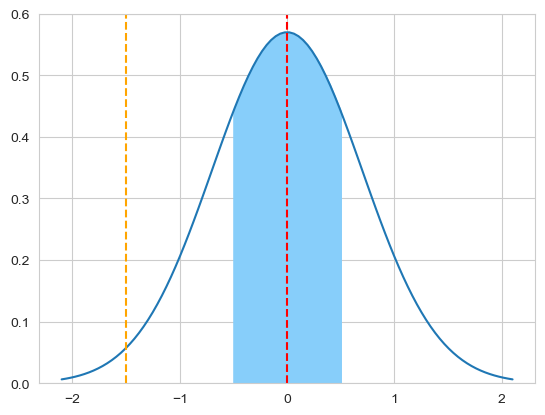

In [209]:
mean=0
std=0.7

x=np.linspace(mean-3*std, mean+3*std,100)
iq=stats.norm(mean,std)
plt.plot(x,iq.pdf(x))
px=np.arange(-0.5,0.6,0.1)
plt.axvline(x=-1.5, ls='--', color='orange')
plt.axvline(x=0, ls='--', color='red')
plt.fill_between(px,iq.pdf(px), color='lightskyblue')
plt.ylim(0,0.6)

plt.show()

In [147]:
point1 = [-1, 0]
point2 = [-1, 0.24]

x_values = [point1[0], point2[0]]

y_values = [point1[1], point2[1]]

In [152]:
y_vals = np.arange(0,8,0.01)
x_vals = -1 * np.ones(800)

### Boxplot of sharpness

In [ ]:
lst1 = ['NgBoost'] * len(ngb_comb_intervals)
lst2 = ['Gaussian Process Regression'] * len(ngb_comb_intervals)

In [ ]:
interval_name = ['crude_interval', 'kuleshov_interval', 'comb1_interval', 'comb2_interval', 'ngb_or_gpr']
sharpness_ngb = pd.DataFrame(columns=interval_name)  
sharpness_gpr = pd.DataFrame(columns=interval_name) 
sharpness_ngb['ngb_or_gpr'] = lst1
sharpness_gpr['ngb_or_gpr'] = lst2

In [ ]:
for i in range(len(ngb_comb_intervals)):
    sharpness_ngb.loc[i, 'crude_interval'] = ngb_crude_range[i,1] - ngb_crude_range[i,0]
    sharpness_ngb.loc[i, 'kuleshov_interval'] = ngb_kuleshov_range[i,1] - ngb_kuleshov_range[i,0]
    sharpness_ngb.loc[i, 'comb1_interval'] = ngb_comb_intervals[i,1] - ngb_comb_intervals[i,0]
    sharpness_ngb.loc[i, 'comb2_interval'] = ngb_comb_intervals2[i,1] - ngb_comb_intervals2[i,0]


In [ ]:
for i in range(len(ngb_comb_intervals)):
    sharpness_gpr.loc[i, 'crude_interval'] = gpr_crude_range[i,1] - gpr_crude_range[i,0]
    sharpness_gpr.loc[i, 'kuleshov_interval'] = gpr_kuleshov_range[i,1] - gpr_kuleshov_range[i,0]
    sharpness_gpr.loc[i, 'comb1_interval'] = gpr_comb_intervals[i,1] - gpr_comb_intervals[i,0]
    sharpness_gpr.loc[i, 'comb2_interval'] = gpr_comb_intervals2[i,1] - gpr_comb_intervals2[i,0]


In [ ]:
frames_ = [sharpness_ngb, sharpness_gpr]
sharpness_boxplot = pd.concat(frames_)

In [ ]:
new_df = pd.melt(sharpness_boxplot.iloc[:,:4])
print(new_df)

In [ ]:
for i in range(len(new_df)):
    if i < len(ngb_crude_range):
        new_df.loc[i, 'ngb_or_gpr'] = 'NgBoost'
    elif i >= len(ngb_crude_range) and i < 2*len(ngb_crude_range):
        new_df.loc[i, 'ngb_or_gpr'] = 'Gaussian Process Regression'
    elif i >= 2*len(ngb_crude_range) and i < 3*len(ngb_crude_range):
        new_df.loc[i, 'ngb_or_gpr'] = 'NgBoost'
    elif i >= 3*len(ngb_crude_range) and i < 4*len(ngb_crude_range):
        new_df.loc[i, 'ngb_or_gpr'] = 'Gaussian Process Regression'
    elif i >= 4*len(ngb_crude_range) and i < 5*len(ngb_crude_range):
        new_df.loc[i, 'ngb_or_gpr'] = 'NgBoost'
    elif i >= 5*len(ngb_crude_range) and i < 6*len(ngb_crude_range):
        new_df.loc[i, 'ngb_or_gpr'] = 'Gaussian Process Regression'
    elif i >= 6*len(ngb_crude_range) and i < 7*len(ngb_crude_range):
        new_df.loc[i, 'ngb_or_gpr'] = 'NgBoost'
    else:
        new_df.loc[i, 'ngb_or_gpr'] = 'Gaussian Process Regression'

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 6))
ax = sns.boxplot(x='variable', y="value", hue='ngb_or_gpr', data=new_df)

### Coverage RMSE

In [98]:
lst = ['cov_uncal_gpr', 'cov_crude_gpr', 'cov_kuleshov_gpr', 'comb_cov_gpr', 'comb_cov_gpr2',
       'cov_uncal_ngb', 'cov_crude_ngb', 'cov_kuleshov_ngb', 'comb_cov_ngb', 'comb_cov_ngb2']
coverages = [cov_uncal_gpr, cov_crude_gpr, cov_kuleshov_calc_gpr, comb_cov_gpr, comb_cov_gpr2,
            cov_uncal_ngb, cov_crude_ngb, cov_kuleshov_calc_ngb, comb_cov_ngb, comb_cov_ngb2]

df = pd.DataFrame(columns=lst)  

In [99]:
for (cov, col) in zip(coverages, lst):
    for i in range(len(cov_unc_gpr)):
        df.loc[i, col] = abs(x[i]-cov[i])

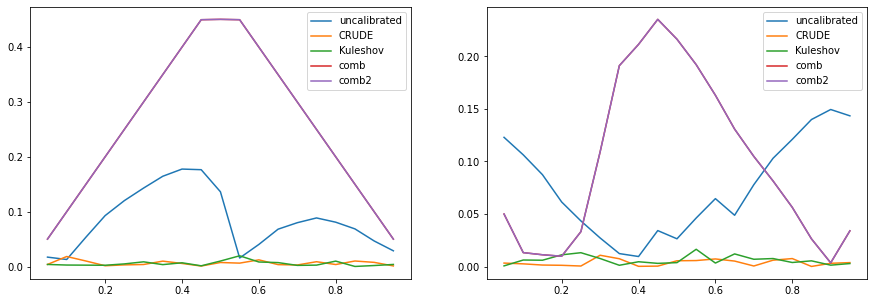

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(x, df.cov_uncal_gpr.values, label='uncalibrated')
ax1.plot(x, df.cov_crude_gpr.values, label='CRUDE')
ax1.plot(x, df.cov_kuleshov_gpr.values, label='Kuleshov')
ax1.plot(x, df.comb_cov_gpr.values, label='comb')
ax1.plot(x, df.comb_cov_gpr2.values, label='comb2')
ax1.legend()

ax2.plot(x, df.cov_uncal_ngb.values, label='uncalibrated')
ax2.plot(x, df.cov_crude_ngb.values, label='CRUDE')
ax2.plot(x, df.cov_kuleshov_ngb.values, label='Kuleshov')
ax2.plot(x, df.comb_cov_ngb.values, label='comb')
ax2.plot(x, df.comb_cov_ngb2.values, label='comb2')
ax2.legend()

plt.show()

In [101]:
rmse = []

for col in lst:
    sum_ = sum(df[col].values)
    rmse.append(sum_/len(df[col]))


In [102]:
for (i, col) in zip(rmse, lst):
    print(col, i)

cov_uncal_gpr 0.0848330252041843
cov_crude_gpr 0.006306896632421416
cov_kuleshov_gpr 0.0053520863073646865
comb_cov_gpr 0.2605602489995554
comb_cov_gpr2 0.2605602489995554
cov_uncal_ngb 0.07505792047927733
cov_crude_ngb 0.003875406613465615
cov_kuleshov_ngb 0.00622030844117857
comb_cov_ngb 0.09859820739041916
comb_cov_ngb2 0.09859820739041916


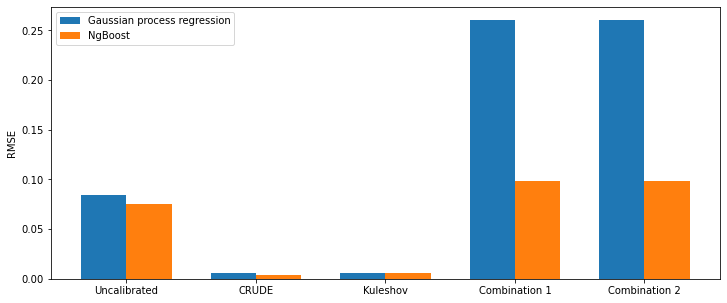

In [103]:
index = np.arange(5)
bar_width = 0.35
gpr = rmse[0:5]
ngb = rmse[5:10]

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.bar(index, gpr, bar_width, label='Gaussian process regression')
plt.bar(index + bar_width, ngb, bar_width, label='NgBoost')
plt.xticks(index + bar_width/2, ('Uncalibrated', 'CRUDE', 'Kuleshov', 'Combination 1', 'Combination 2'))
plt.ylabel('RMSE')

plt.legend()
plt.show()

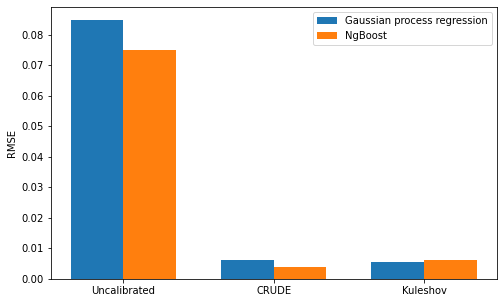

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.bar(index[0:3], gpr[0:3], bar_width, label='Gaussian process regression')
plt.bar(index[0:3] + bar_width, ngb[0:3], bar_width, label='NgBoost')
plt.xticks(index[0:3] + bar_width/2, ('Uncalibrated', 'CRUDE', 'Kuleshov'))
plt.ylabel('RMSE')

plt.legend()
plt.show()